In [ ]:
!pip install medmnist
!pip install torcheval
!pip install pytorch-ignite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_c

In [ ]:
from tqdm import tqdm
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.functional as F

from torcheval.metrics import MulticlassAUPRC
from torcheval.metrics.functional import multiclass_f1_score

from collections import OrderedDict

from ignite.engine import *
from ignite.handlers import *
from ignite.metrics import *
from ignite.metrics.regression import *
from ignite.utils import *

import medmnist
from medmnist import INFO, Evaluator

from sklearn.metrics import precision_score, average_precision_score, recall_score, f1_score, ConfusionMatrixDisplay, confusion_matrix, RocCurveDisplay, roc_curve, PrecisionRecallDisplay, precision_recall_curve

import matplotlib.pyplot as plt

import random


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)



cpu


In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(66)
torch.autograd.set_detect_anomaly(True)

# Data Preprocessing

In [ ]:
data_flag = 'breastmnist'
download = True

# Hyperparameters
NUM_EPOCHS = 100 #11
BATCH_SIZE = 64 #96
lr = 0.01 #0.005, 0.01

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

data_transform = transforms.Compose([
    transforms.Resize(224), #256 or 224
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

In [ ]:
# Load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)
pil_dataset = DataClass(split='train', download=download)
val_dataset = DataClass(split='val', transform=data_transform, download=download)

# Encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

100%|██████████| 559580/559580 [00:00<00:00, 1135512.47it/s]


Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz


# Resnet-18 Model

In [ ]:
class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        # Modify the first convolutional layer to accept input with 1 channel
        self.resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Modify the final fully connected layer to match the number of classes
        self.dropout = nn.Dropout(p=0.5)
        num_ftrs = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, num_classes))

    def forward(self, x):
        x = self.resnet18(x)

        return x

# Applies dropout layers after each ReLU
# def append_dropout(model, rate=0.3):
#     for name, module in model.named_children():
#         if len(list(module.children())) > 0:
#             append_dropout(module)
#         if isinstance(module, nn.ReLU):
#             new = nn.Sequential(module, nn.Dropout2d(p=rate, inplace=False))
#             setattr(model, name, new)


model = ResNet18(n_classes).to(device)
# append_dropout(model)


print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 94.4MB/s]


ResNet18(
  (resnet18): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [ ]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
#optimizer = torch.optim.Adam(model.parameters())

In [ ]:
def accuracy(output, target):
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(target.view_as(pred)).sum().item()
    return correct / len(target)

In [ ]:
# Early Stopping Function
class EarlyStopper:
    def __init__(self, patience=1):
        self.patience = patience
        self.min_delta = 0
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        self.min_delta = validation_loss / 4

        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0

        elif validation_loss > self.min_validation_loss:
          self.counter += 0.5
          if self.counter >= self.patience:
            return True

        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
# Learning Rate Scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.1)

### **Grid Search**

In [ ]:
def grid_test(split):
    model.eval()
    y_true = torch.tensor([]).to(device)
    y_score = torch.tensor([]).to(device)
    y_pred = torch.tensor([]).to(device)

    if split == 'val':
        data_loader = val_loader
    else:
        data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            pred = outputs.argmax(dim=1, keepdim=True)
            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0) #The true targets
            y_score = torch.cat((y_score, outputs), 0) #The model outputs from the data loader (probabilities)
            y_pred = torch.cat((y_pred, pred), 0) #Predicted targets

        x = y_true.squeeze()
        y = y_score
        p = y_pred.squeeze()
        y_true = y_true.cpu().numpy()
        y_score = y_score.cpu().detach().numpy()
        y_pred = y_pred.cpu().detach().numpy()

        #Metrics AUC and ACC
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))
        return metrics

def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    #print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()


In [ ]:
#Parameter grids for grid search
import itertools
lr_grid = [0.001, 0.005, 0.01, 0.05, 0.1]
batch_grid = [32, 64, 96, 128]
momentum_grid = [0.8, 0.85, 0.9]

#Epoch grid not needed because of early stopping
grid = list(itertools.product(lr_grid, batch_grid, momentum_grid))

#Use this for loop to do grid search but also remember to define the model within this loop so the weights reset
all_acc = []

#Set to true to run grid search
grid_true = False

results = []
if grid_true:
  for comb in grid:
    print(comb)
    import torch.utils.data as data
    #Data Loaders
    train_dataset = DataClass(split='train', transform=data_transform, download=download)
    test_dataset = DataClass(split='test', transform=data_transform, download=download)
    pil_dataset = DataClass(split='train', download=download)
    val_dataset = DataClass(split='val', transform=data_transform, download=download)

    train_loader = data.DataLoader(dataset=train_dataset, batch_size=comb[1], shuffle=True)
    train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*comb[1], shuffle=False)
    test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*comb[1], shuffle=False)
    val_loader = data.DataLoader(dataset=val_dataset, batch_size=2*comb[1], shuffle=False)

    #Loss Function
    criterion = nn.CrossEntropyLoss()
    #Optimiser
    #optimizer = torch.optim.Adam(model.parameters(), lr=comb[0])
    optimizer = torch.optim.SGD(model.parameters(), lr=comb[0], momentum=comb[2])
    #ResNet-18
    model = ResNet18(n_classes).to(device)
    #Early Stopping
    early_stopper = EarlyStopper(patience=3)
    #Learning Rate Scheduler
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.1)

    for epoch in range(NUM_EPOCHS):
      print(f"Epoch Number - {epoch}")
      train_loss = 0.0
      train_accuracy = 0.0
      model.train()

      # Training Loop
      for inputs, targets in tqdm(train_loader):
          optimizer.zero_grad()
          inputs, targets = inputs.to(device), targets.to(device)
          outputs = model(inputs)

          if task == 'multi-label, binary-class':
              targets = targets.to(torch.float32)
              loss = criterion(outputs, targets)
          else:
              targets = targets.squeeze().long()
              loss = criterion(outputs, targets)

          loss.backward()
          optimizer.step()

          train_loss += loss.item()
          train_accuracy += accuracy(outputs, targets)

      print('Train - Loss: {:.6f}, Accuracy: {:.2f}%'.format(train_loss / len(train_loader), train_accuracy / len(train_loader) * 100))

      # Validation Loop
      model.eval()
      valid_loss = 0
      valid_accuracy = 0
      with torch.no_grad():
        for data, label in val_loader:
            data, label = data.to(device), label.to(device)
            output = model(data)

            label = label.squeeze().long()
            loss = criterion(output, label)

            valid_loss += loss.item()
            valid_accuracy += accuracy(output, label)
      print('Validation - Loss: {:.6f}, Accuracy: {:.2f}%'.format(valid_loss / len(val_loader), valid_accuracy / len(val_loader) * 100))

      scheduler.step(valid_loss)
      current_lr = scheduler.get_last_lr()
      print("Current lr:", current_lr)

      if early_stopper.early_stop(valid_loss):
          break

    results.append(grid_test('test'))
  print(results)



### **Training**

In [ ]:
# Training
if not grid_true:
  early_stopper = EarlyStopper(patience=3)
  for epoch in range(NUM_EPOCHS):
      print(f"Epoch Number - {epoch}")
      train_loss = 0.0
      train_accuracy = 0.0
      model.train()

      # Training Loop
      for inputs, targets in tqdm(train_loader):
          optimizer.zero_grad()
          inputs, targets = inputs.to(device), targets.to(device)
          outputs = model(inputs)

          if task == 'multi-label, binary-class':
              targets = targets.to(torch.float32)
              loss = criterion(outputs, targets)
          else:
              targets = targets.squeeze().long()
              loss = criterion(outputs, targets)

          loss.backward()
          optimizer.step()

          train_loss += loss.item()
          train_accuracy += accuracy(outputs, targets)

      print('Train - Loss: {:.6f}, Accuracy: {:.2f}%'.format(train_loss / len(train_loader), train_accuracy / len(train_loader) * 100))

      # Validation Loop
      model.eval()
      valid_loss = 0
      valid_accuracy = 0
      with torch.no_grad():
        for data, label in val_loader:
            data, label = data.to(device), label.to(device)
            output = model(data)

            label = label.squeeze().long()
            loss = criterion(output, label)

            valid_loss += loss.item()
            valid_accuracy += accuracy(output, label)
      print('Validation - Loss: {:.6f}, Accuracy: {:.2f}%'.format(valid_loss / len(val_loader), valid_accuracy / len(val_loader) * 100))

      scheduler.step(valid_loss)
      current_lr = scheduler.get_last_lr()
      print("Current lr:", current_lr)

      if early_stopper.early_stop(valid_loss):
          break

Epoch Number - 0


100%|██████████| 9/9 [03:19<00:00, 22.20s/it]


Train - Loss: 0.979816, Accuracy: 63.04%
Validation - Loss: 0.706325, Accuracy: 48.72%
Current lr: [0.01]
Epoch Number - 1


100%|██████████| 9/9 [02:59<00:00, 19.97s/it]


Train - Loss: 0.622415, Accuracy: 75.84%
Validation - Loss: 1.222208, Accuracy: 46.15%
Current lr: [0.01]
Epoch Number - 2


100%|██████████| 9/9 [03:03<00:00, 20.38s/it]


Train - Loss: 0.426732, Accuracy: 82.51%
Validation - Loss: 0.721836, Accuracy: 70.51%
Current lr: [0.001]
Epoch Number - 3


100%|██████████| 9/9 [02:57<00:00, 19.76s/it]


Train - Loss: 0.226118, Accuracy: 91.88%
Validation - Loss: 0.589255, Accuracy: 73.08%
Current lr: [0.001]
Epoch Number - 4


100%|██████████| 9/9 [02:56<00:00, 19.63s/it]


Train - Loss: 0.162365, Accuracy: 93.62%
Validation - Loss: 0.341805, Accuracy: 87.18%
Current lr: [0.001]
Epoch Number - 5


100%|██████████| 9/9 [02:57<00:00, 19.71s/it]


Train - Loss: 0.116138, Accuracy: 94.97%
Validation - Loss: 0.306625, Accuracy: 92.31%
Current lr: [0.001]
Epoch Number - 6


100%|██████████| 9/9 [02:53<00:00, 19.26s/it]


Train - Loss: 0.106567, Accuracy: 95.53%
Validation - Loss: 0.288026, Accuracy: 93.59%
Current lr: [0.001]
Epoch Number - 7


100%|██████████| 9/9 [02:54<00:00, 19.37s/it]


Train - Loss: 0.085144, Accuracy: 97.59%
Validation - Loss: 0.317099, Accuracy: 92.31%
Current lr: [0.001]
Epoch Number - 8


100%|██████████| 9/9 [02:55<00:00, 19.48s/it]


Train - Loss: 0.071471, Accuracy: 97.44%
Validation - Loss: 0.324844, Accuracy: 93.59%
Current lr: [0.0001]
Epoch Number - 9


100%|██████████| 9/9 [02:54<00:00, 19.35s/it]


Train - Loss: 0.062347, Accuracy: 97.63%
Validation - Loss: 0.303998, Accuracy: 93.59%
Current lr: [0.0001]
Epoch Number - 10


100%|██████████| 9/9 [02:54<00:00, 19.39s/it]


Train - Loss: 0.053374, Accuracy: 98.13%
Validation - Loss: 0.278175, Accuracy: 93.59%
Current lr: [0.0001]
Epoch Number - 11


100%|██████████| 9/9 [02:54<00:00, 19.38s/it]


Train - Loss: 0.045671, Accuracy: 99.48%
Validation - Loss: 0.275929, Accuracy: 93.59%
Current lr: [0.0001]
Epoch Number - 12


100%|██████████| 9/9 [02:58<00:00, 19.86s/it]


Train - Loss: 0.046528, Accuracy: 98.81%
Validation - Loss: 0.277619, Accuracy: 93.59%
Current lr: [0.0001]
Epoch Number - 13


100%|██████████| 9/9 [02:55<00:00, 19.49s/it]


Train - Loss: 0.048835, Accuracy: 98.61%
Validation - Loss: 0.270746, Accuracy: 93.59%
Current lr: [0.0001]
Epoch Number - 14


100%|██████████| 9/9 [02:57<00:00, 19.67s/it]


Train - Loss: 0.050012, Accuracy: 98.98%
Validation - Loss: 0.274819, Accuracy: 93.59%
Current lr: [0.0001]
Epoch Number - 15


100%|██████████| 9/9 [03:00<00:00, 20.02s/it]


Train - Loss: 0.053739, Accuracy: 98.09%
Validation - Loss: 0.279553, Accuracy: 93.59%
Current lr: [1e-05]
Epoch Number - 16


100%|██████████| 9/9 [02:55<00:00, 19.49s/it]


Train - Loss: 0.054589, Accuracy: 98.78%
Validation - Loss: 0.272154, Accuracy: 93.59%
Current lr: [1e-05]
Epoch Number - 17


100%|██████████| 9/9 [02:52<00:00, 19.17s/it]


Train - Loss: 0.043397, Accuracy: 99.15%
Validation - Loss: 0.281390, Accuracy: 93.59%
Current lr: [1.0000000000000002e-06]
Epoch Number - 18


100%|██████████| 9/9 [02:51<00:00, 19.07s/it]


Train - Loss: 0.053310, Accuracy: 98.78%
Validation - Loss: 0.280252, Accuracy: 93.59%
Current lr: [1.0000000000000002e-06]
Epoch Number - 19


100%|██████████| 9/9 [02:55<00:00, 19.53s/it]


Train - Loss: 0.039659, Accuracy: 99.33%
Validation - Loss: 0.275531, Accuracy: 93.59%
Current lr: [1.0000000000000002e-07]


### Evaluates Performance

==> Evaluating ...
train  auc: 1.000  acc:1.000
AUPR: 0.9999999
Precision: 1.0
Recall Score: 1.0
F1 Score: 1.0
----------------------


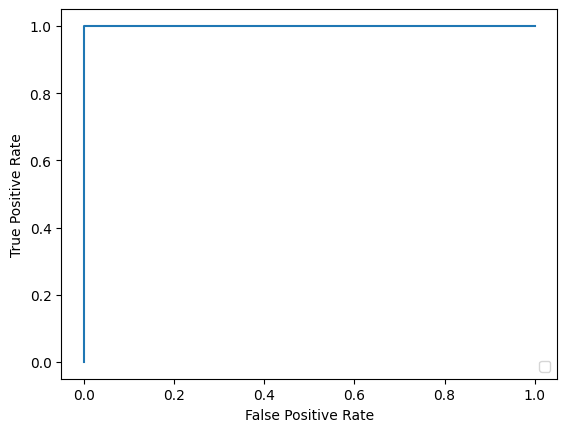

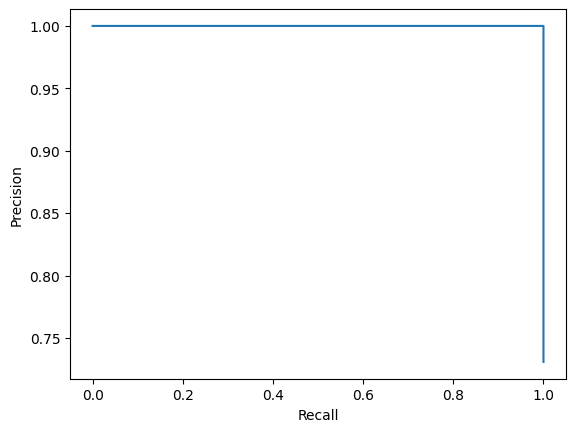

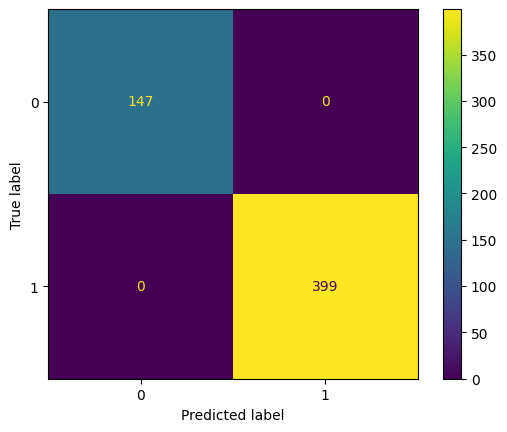

In [ ]:
# Evaluation
def test(split):
    model.eval()
    y_true = torch.tensor([]).to(device)
    y_score = torch.tensor([]).to(device)
    y_pred = torch.tensor([]).to(device)

    if split == 'val':
        data_loader = val_loader
    else:
        data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            pred = outputs.argmax(dim=1, keepdim=True)
            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0) #The true targets
            y_score = torch.cat((y_score, outputs), 0) #The model outputs from the data loader (probabilities)
            y_pred = torch.cat((y_pred, pred), 0) #Predicted targets

        x = y_true.squeeze()
        y = y_score
        p = y_pred.squeeze()
        y_true = y_true.cpu().numpy()
        y_score = y_score.cpu().detach().numpy()
        y_pred = y_pred.cpu().detach().numpy()

        #Metrics AUC and ACC
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

        #AUPR
        aupr = MulticlassAUPRC(num_classes=n_classes)
        aupr.update(y, x)
        print("AUPR:", aupr.compute().cpu().detach().numpy())


        #Precision
        print("Precision:", precision_score(y_true.flatten(), y_pred.flatten()))

        #Recall
        print("Recall Score:", recall_score(y_true, y_pred))

        #F1 Score
        print("F1 Score:", f1_score(y_true, y_pred))
        print("----------------------")

        #Graphs
        #ROC Curve
        fpr, tpr, _ = roc_curve(y_true, y_score[:, 1])
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

        #Precision Recall Graph
        prec, recall, _ = precision_recall_curve(y_true, y_score[:, 1])
        pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

        #Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        cm_display = ConfusionMatrixDisplay(cm).plot()


print('==> Evaluating ...')
test('train')

test  auc: 0.912  acc:0.904
AUPR: 0.873999
Precision: 0.9380530973451328
Recall Score: 0.9298245614035088
F1 Score: 0.933920704845815
----------------------


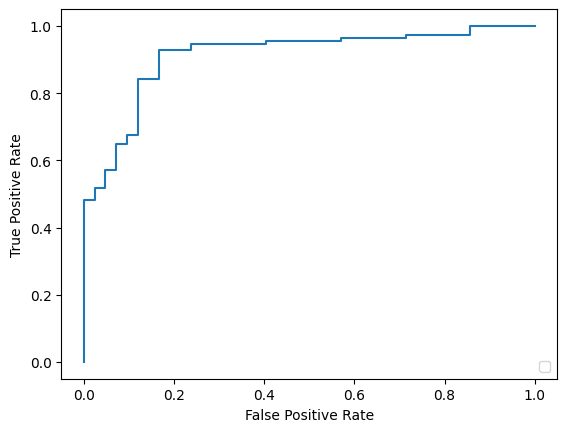

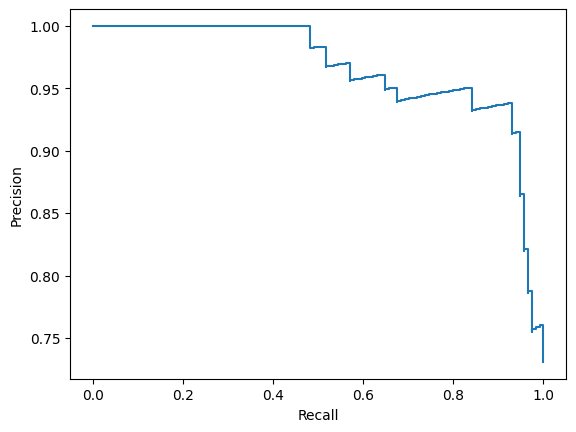

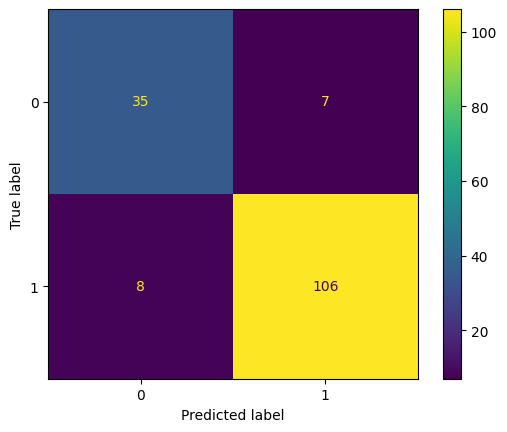

In [ ]:
test('test')
# With ADAM
# test  auc: 0.922  acc:0.878
# AUPR: 0.88461226
# Precision: 0.8467656415694591
# Recall Score: 0.8414786967418546
# F1 Score: 0.9170305676855894
# F1 Score: 0.8782051

# test  auc: 0.924  acc:0.853
# AUPR: 0.90371984
# Precision: 0.8136797454931071
# Recall Score: 0.8088972431077694
# F1 Score: 0.8995633187772927
# F1 Score: 0.8525641

#With SGD
# test  auc: 0.911  acc:0.891
# AUPR: 0.87521255
# Precision: 0.8573573573573574
# Recall Score: 0.8728070175438596
# F1 Score: 0.9244444444444444
# F1 Score: 0.89102566

# test  auc: 0.907  acc:0.885
# AUPR: 0.88412863
# Precision: 0.8666666666666667
# Recall Score: 0.8308270676691729
# F1 Score: 0.9230769230769231
# F1 Score: 0.88461536



val  auc: 0.935  acc:0.936
AUPR: 0.9453782
Precision: 0.9193548387096774
Recall Score: 1.0
F1 Score: 0.9579831932773109
----------------------


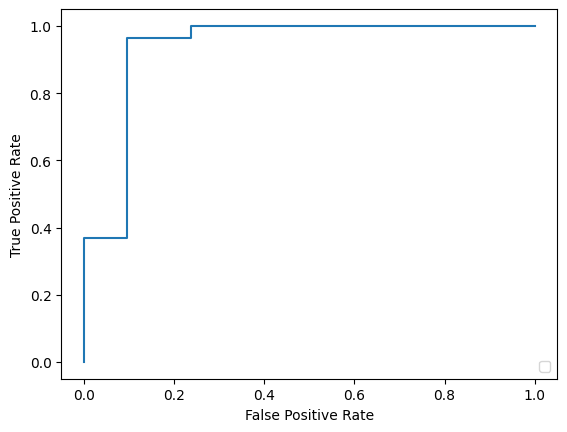

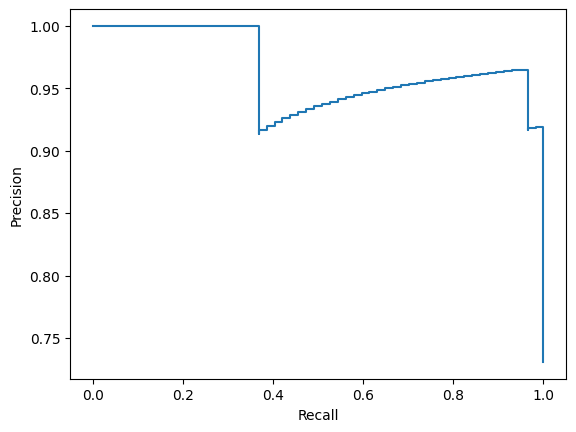

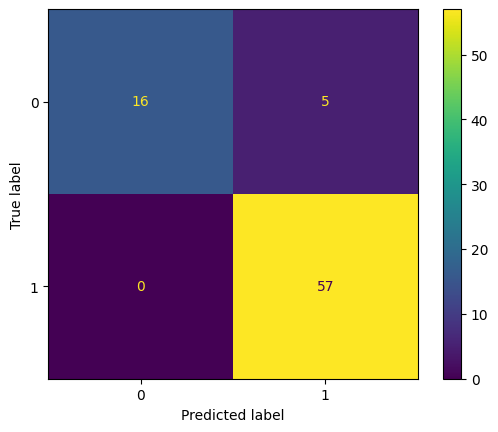

In [ ]:
test('val')

### K-Fold Cross Validation


In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

In [ ]:
dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset, test_dataset])
print(dataset)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.1)

In [ ]:
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)
total_accuracy = 0.0
total_auc = 0.0
#5-Fold Cross Validation
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    print(f'Fold: {fold}')

    kf = KFold(n_splits=4, shuffle=False)
    early_stopper = EarlyStopper(patience=3)

    # Splits the training set into train and validation
    for in_fold, (train_idx, val_idx) in enumerate(kf.split(train_ids)):
        sub_train = torch.utils.data.SubsetRandomSampler(train_idx)
        sub_val = torch.utils.data.SubsetRandomSampler(val_idx)
        break

    sub_test = torch.utils.data.SubsetRandomSampler(test_ids)

    train_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=BATCH_SIZE, sampler=sub_train)
    val_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=BATCH_SIZE*2, sampler=sub_val)
    test_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=BATCH_SIZE*2, sampler=sub_test)


    model = ResNet18(n_classes).to(device)
    model.apply(reset_weights)

    optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

    for epoch in range(NUM_EPOCHS):
        print(f"Epoch Number - {epoch}")
        train_loss = 0.0
        train_accuracy = 0.0
        model.train()

        #Training Loop
        for inputs, targets in tqdm(train_loader):
            optimizer.zero_grad()
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                loss = criterion(outputs, targets)
            else:
                targets = targets.squeeze().long()
                loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_accuracy += accuracy(outputs, targets)

        print('Train - Loss: {:.6f}, Accuracy: {:.2f}%'.format(train_loss / len(train_loader), train_accuracy / len(train_loader) * 100))

        #Validation Loop
        model.eval()
        valid_loss = 0
        valid_accuracy = 0
        with torch.no_grad():
            for data, label in val_loader:
                data, label = data.to(device), label.to(device)
                output = model(data)

                label = label.squeeze().long()
                loss = criterion(output, label)

                valid_loss += loss.item()
                valid_accuracy += accuracy(output, label)

        print('Validation - Loss: {:.6f}, Accuracy: {:.2f}%'.format(valid_loss / len(val_loader), valid_accuracy / len(val_loader) * 100))

        if early_stopper.early_stop(valid_loss):
            break

        scheduler.step(valid_loss)


    #Testing Loop
    model.eval()
    test_loss = 0
    test_accuracy = 0
    y_true = torch.tensor([]).to(device)
    y_score = torch.tensor([]).to(device)
    y_pred = torch.tensor([]).to(device)
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            y_outputs = model(inputs)
            predicted = y_outputs.argmax(dim=1, keepdim=True)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                y_outputs = y_outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                y_outputs = y_outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)


            y_true = torch.cat((y_true, targets), 0) # The true targets
            y_score = torch.cat((y_score, y_outputs), 0) # The model outputs from the data loader (probabilities)
            y_pred = torch.cat((y_pred, predicted), 0) # Predicted targets

            test_loss += loss.item()
            test_accuracy += accuracy(y_outputs, targets)

        y_true = y_true.cpu().numpy()
        y_score = y_score.cpu().detach().numpy()
        y_pred = y_pred.cpu().detach().numpy()

        auc = roc_auc_score(y_true, y_score[:, 1])
        total_auc += auc
        total_accuracy += (test_accuracy / len(test_loader) * 100)
    print('Test - Loss: {:.6f}, Accuracy: {:.2f}%'.format(test_loss / len(test_loader), test_accuracy / len(test_loader) * 100))
    print('AUC -', auc)


Fold: 0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch Number - 0


100%|██████████| 8/8 [02:30<00:00, 18.79s/it]


Train - Loss: 0.659636, Accuracy: 65.78%
Validation - Loss: 0.649813, Accuracy: 77.34%
Epoch Number - 1


100%|██████████| 8/8 [02:29<00:00, 18.71s/it]


Train - Loss: 0.604159, Accuracy: 72.23%
Validation - Loss: 0.640112, Accuracy: 79.74%
Epoch Number - 2


100%|██████████| 8/8 [02:26<00:00, 18.31s/it]


Train - Loss: 0.537290, Accuracy: 74.88%
Validation - Loss: 0.757295, Accuracy: 39.06%
Epoch Number - 3


100%|██████████| 8/8 [02:23<00:00, 17.94s/it]


Train - Loss: 0.473817, Accuracy: 77.30%
Validation - Loss: 0.506541, Accuracy: 70.42%
Epoch Number - 4


100%|██████████| 8/8 [02:24<00:00, 18.03s/it]


Train - Loss: 0.374539, Accuracy: 81.91%
Validation - Loss: 0.396257, Accuracy: 83.09%
Epoch Number - 5


100%|██████████| 8/8 [02:24<00:00, 18.00s/it]


Train - Loss: 0.352512, Accuracy: 87.93%
Validation - Loss: 0.538067, Accuracy: 84.88%
Epoch Number - 6


100%|██████████| 8/8 [02:30<00:00, 18.80s/it]


Train - Loss: 0.315364, Accuracy: 86.17%
Validation - Loss: 0.457102, Accuracy: 86.27%
Epoch Number - 7


100%|██████████| 8/8 [02:30<00:00, 18.80s/it]


Train - Loss: 0.325199, Accuracy: 83.48%
Validation - Loss: 0.632423, Accuracy: 78.29%
Epoch Number - 8


100%|██████████| 8/8 [02:30<00:00, 18.83s/it]


Train - Loss: 0.217108, Accuracy: 90.12%
Validation - Loss: 4.011232, Accuracy: 77.34%
Epoch Number - 9


100%|██████████| 8/8 [02:30<00:00, 18.85s/it]


Train - Loss: 0.202311, Accuracy: 91.25%
Validation - Loss: 0.492400, Accuracy: 82.48%
Epoch Number - 10


100%|██████████| 8/8 [02:26<00:00, 18.35s/it]


Train - Loss: 0.220830, Accuracy: 90.98%
Validation - Loss: 4.913939, Accuracy: 78.74%
Test - Loss: 5.486354, Accuracy: 77.18%
AUC - 0.5651828298887122
Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch Number - 0


100%|██████████| 8/8 [02:28<00:00, 18.50s/it]


Train - Loss: 0.608322, Accuracy: 68.79%
Validation - Loss: 0.657081, Accuracy: 80.13%
Epoch Number - 1


100%|██████████| 8/8 [02:24<00:00, 18.07s/it]


Train - Loss: 0.590917, Accuracy: 72.70%
Validation - Loss: 0.637500, Accuracy: 78.12%
Epoch Number - 2


100%|██████████| 8/8 [02:25<00:00, 18.16s/it]


Train - Loss: 0.522796, Accuracy: 75.16%
Validation - Loss: 0.615154, Accuracy: 76.95%
Epoch Number - 3


100%|██████████| 8/8 [02:28<00:00, 18.61s/it]


Train - Loss: 0.463087, Accuracy: 77.34%
Validation - Loss: 0.619674, Accuracy: 75.95%
Epoch Number - 4


100%|██████████| 8/8 [02:22<00:00, 17.82s/it]


Train - Loss: 0.457772, Accuracy: 77.50%
Validation - Loss: 0.660731, Accuracy: 64.01%
Epoch Number - 5


100%|██████████| 8/8 [02:23<00:00, 17.93s/it]


Train - Loss: 0.398817, Accuracy: 82.11%
Validation - Loss: 0.456981, Accuracy: 77.57%
Epoch Number - 6


100%|██████████| 8/8 [02:24<00:00, 18.02s/it]


Train - Loss: 0.291061, Accuracy: 89.61%
Validation - Loss: 1.063942, Accuracy: 77.73%
Epoch Number - 7


100%|██████████| 8/8 [02:21<00:00, 17.65s/it]


Train - Loss: 0.233929, Accuracy: 89.77%
Validation - Loss: 0.398414, Accuracy: 81.08%
Epoch Number - 8


100%|██████████| 8/8 [02:19<00:00, 17.41s/it]


Train - Loss: 0.183090, Accuracy: 92.34%
Validation - Loss: 1.013043, Accuracy: 82.70%
Epoch Number - 9


100%|██████████| 8/8 [02:21<00:00, 17.66s/it]


Train - Loss: 0.212497, Accuracy: 91.68%
Validation - Loss: 2.023284, Accuracy: 82.31%
Epoch Number - 10


100%|██████████| 8/8 [02:24<00:00, 18.08s/it]


Train - Loss: 0.252073, Accuracy: 89.96%
Validation - Loss: 5.498525, Accuracy: 74.55%
Epoch Number - 11


100%|██████████| 8/8 [02:31<00:00, 18.92s/it]


Train - Loss: 0.253944, Accuracy: 90.55%
Validation - Loss: 1.556835, Accuracy: 81.86%
Epoch Number - 12


100%|██████████| 8/8 [02:25<00:00, 18.17s/it]


Train - Loss: 0.247086, Accuracy: 89.57%
Validation - Loss: 1.670658, Accuracy: 48.55%
Epoch Number - 13


100%|██████████| 8/8 [02:26<00:00, 18.28s/it]


Train - Loss: 0.157955, Accuracy: 92.34%
Validation - Loss: 1.224148, Accuracy: 78.52%
Test - Loss: 1.176926, Accuracy: 78.96%
AUC - 0.9749391233766234
Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch Number - 0


100%|██████████| 8/8 [02:23<00:00, 17.92s/it]


Train - Loss: 0.709413, Accuracy: 65.00%
Validation - Loss: 0.591478, Accuracy: 78.74%
Epoch Number - 1


100%|██████████| 8/8 [02:25<00:00, 18.23s/it]


Train - Loss: 0.546008, Accuracy: 73.05%
Validation - Loss: 0.606752, Accuracy: 75.95%
Epoch Number - 2


100%|██████████| 8/8 [02:23<00:00, 17.88s/it]


Train - Loss: 0.510469, Accuracy: 75.47%
Validation - Loss: 0.556253, Accuracy: 76.95%
Epoch Number - 3


100%|██████████| 8/8 [02:21<00:00, 17.67s/it]


Train - Loss: 0.473428, Accuracy: 77.27%
Validation - Loss: 0.454579, Accuracy: 78.35%
Epoch Number - 4


100%|██████████| 8/8 [02:23<00:00, 17.98s/it]


Train - Loss: 0.388923, Accuracy: 82.27%
Validation - Loss: 0.510163, Accuracy: 69.87%
Epoch Number - 5


100%|██████████| 8/8 [02:23<00:00, 17.90s/it]


Train - Loss: 0.331473, Accuracy: 85.23%
Validation - Loss: 0.650058, Accuracy: 78.35%
Epoch Number - 6


100%|██████████| 8/8 [02:25<00:00, 18.24s/it]


Train - Loss: 0.286301, Accuracy: 87.03%
Validation - Loss: 0.332492, Accuracy: 87.05%
Epoch Number - 7


100%|██████████| 8/8 [02:23<00:00, 17.89s/it]


Train - Loss: 0.240468, Accuracy: 89.53%
Validation - Loss: 0.468402, Accuracy: 77.34%
Epoch Number - 8


100%|██████████| 8/8 [02:21<00:00, 17.71s/it]


Train - Loss: 0.160231, Accuracy: 94.65%
Validation - Loss: 1.311056, Accuracy: 79.91%
Epoch Number - 9


100%|██████████| 8/8 [02:24<00:00, 18.03s/it]


Train - Loss: 0.144759, Accuracy: 94.73%
Validation - Loss: 0.551941, Accuracy: 84.21%
Epoch Number - 10


100%|██████████| 8/8 [02:23<00:00, 17.97s/it]


Train - Loss: 0.216303, Accuracy: 92.97%
Validation - Loss: 0.885792, Accuracy: 69.87%
Epoch Number - 11


100%|██████████| 8/8 [02:22<00:00, 17.85s/it]


Train - Loss: 0.200843, Accuracy: 91.80%
Validation - Loss: 0.554798, Accuracy: 87.61%
Epoch Number - 12


100%|██████████| 8/8 [02:26<00:00, 18.37s/it]


Train - Loss: 0.226765, Accuracy: 91.48%
Validation - Loss: 0.825912, Accuracy: 71.71%
Test - Loss: 0.510665, Accuracy: 75.56%
AUC - 0.939139139139139
Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch Number - 0


100%|██████████| 8/8 [02:23<00:00, 17.93s/it]


Train - Loss: 0.639742, Accuracy: 67.19%
Validation - Loss: 0.654117, Accuracy: 75.95%
Epoch Number - 1


100%|██████████| 8/8 [02:24<00:00, 18.10s/it]


Train - Loss: 0.617438, Accuracy: 69.61%
Validation - Loss: 0.746598, Accuracy: 21.26%
Epoch Number - 2


100%|██████████| 8/8 [02:23<00:00, 17.88s/it]


Train - Loss: 0.556832, Accuracy: 75.27%
Validation - Loss: 0.646391, Accuracy: 67.75%
Epoch Number - 3


100%|██████████| 8/8 [02:22<00:00, 17.76s/it]


Train - Loss: 0.532072, Accuracy: 75.55%
Validation - Loss: 0.452193, Accuracy: 81.92%
Epoch Number - 4


100%|██████████| 8/8 [02:23<00:00, 17.98s/it]


Train - Loss: 0.440660, Accuracy: 78.36%
Validation - Loss: 3.750883, Accuracy: 77.34%
Epoch Number - 5


100%|██████████| 8/8 [02:23<00:00, 17.99s/it]


Train - Loss: 0.378868, Accuracy: 84.65%
Validation - Loss: 1.144053, Accuracy: 82.92%
Epoch Number - 6


100%|██████████| 8/8 [02:22<00:00, 17.80s/it]


Train - Loss: 0.450066, Accuracy: 82.03%
Validation - Loss: 1.037108, Accuracy: 77.73%
Epoch Number - 7


100%|██████████| 8/8 [02:26<00:00, 18.30s/it]


Train - Loss: 0.292105, Accuracy: 88.63%
Validation - Loss: 1.502199, Accuracy: 74.55%
Epoch Number - 8


100%|██████████| 8/8 [02:23<00:00, 17.92s/it]


Train - Loss: 0.251744, Accuracy: 89.61%
Validation - Loss: 1.764625, Accuracy: 74.55%
Epoch Number - 9


100%|██████████| 8/8 [02:23<00:00, 17.97s/it]


Train - Loss: 0.156541, Accuracy: 93.55%
Validation - Loss: 0.422605, Accuracy: 83.09%
Epoch Number - 10


100%|██████████| 8/8 [02:22<00:00, 17.87s/it]


Train - Loss: 0.103762, Accuracy: 95.39%
Validation - Loss: 0.488021, Accuracy: 84.10%
Epoch Number - 11


100%|██████████| 8/8 [02:21<00:00, 17.69s/it]


Train - Loss: 0.102254, Accuracy: 96.88%
Validation - Loss: 0.992494, Accuracy: 81.47%
Epoch Number - 12


100%|██████████| 8/8 [02:23<00:00, 17.99s/it]


Train - Loss: 0.090648, Accuracy: 96.60%
Validation - Loss: 0.796817, Accuracy: 79.91%
Epoch Number - 13


100%|██████████| 8/8 [02:23<00:00, 17.94s/it]


Train - Loss: 0.153651, Accuracy: 94.26%
Validation - Loss: 0.916557, Accuracy: 72.10%
Epoch Number - 14


100%|██████████| 8/8 [02:23<00:00, 18.00s/it]


Train - Loss: 0.099358, Accuracy: 95.66%
Validation - Loss: 1.022554, Accuracy: 83.48%
Epoch Number - 15


100%|██████████| 8/8 [02:30<00:00, 18.80s/it]


Train - Loss: 0.101898, Accuracy: 96.84%
Validation - Loss: 0.656064, Accuracy: 82.48%
Test - Loss: 0.700778, Accuracy: 80.86%
AUC - 0.929811320754717
Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch Number - 0


100%|██████████| 8/8 [02:25<00:00, 18.23s/it]


Train - Loss: 0.632524, Accuracy: 66.88%
Validation - Loss: 0.650739, Accuracy: 75.95%
Epoch Number - 1


100%|██████████| 8/8 [02:23<00:00, 17.90s/it]


Train - Loss: 0.596500, Accuracy: 69.53%
Validation - Loss: 0.667530, Accuracy: 67.52%
Epoch Number - 2


100%|██████████| 8/8 [02:21<00:00, 17.71s/it]


Train - Loss: 0.560360, Accuracy: 75.04%
Validation - Loss: 1.267245, Accuracy: 17.47%
Epoch Number - 3


100%|██████████| 8/8 [02:23<00:00, 17.96s/it]


Train - Loss: 0.475122, Accuracy: 78.83%
Validation - Loss: 0.521102, Accuracy: 76.95%
Epoch Number - 4


100%|██████████| 8/8 [02:23<00:00, 17.96s/it]


Train - Loss: 0.448961, Accuracy: 79.53%
Validation - Loss: 0.351679, Accuracy: 84.10%
Epoch Number - 5


100%|██████████| 8/8 [02:22<00:00, 17.80s/it]


Train - Loss: 0.398487, Accuracy: 82.50%
Validation - Loss: 0.384241, Accuracy: 85.83%
Epoch Number - 6


100%|██████████| 8/8 [02:26<00:00, 18.30s/it]


Train - Loss: 0.335646, Accuracy: 86.41%
Validation - Loss: 0.688446, Accuracy: 82.48%
Epoch Number - 7


100%|██████████| 8/8 [02:22<00:00, 17.81s/it]


Train - Loss: 0.336893, Accuracy: 86.68%
Validation - Loss: 0.855291, Accuracy: 81.70%
Epoch Number - 8


100%|██████████| 8/8 [02:21<00:00, 17.64s/it]


Train - Loss: 0.259387, Accuracy: 87.50%
Validation - Loss: 2.139501, Accuracy: 81.53%
Epoch Number - 9


100%|██████████| 8/8 [02:26<00:00, 18.29s/it]


Train - Loss: 0.222343, Accuracy: 90.70%
Validation - Loss: 2.175711, Accuracy: 77.34%
Epoch Number - 10


100%|██████████| 8/8 [02:24<00:00, 18.01s/it]


Train - Loss: 0.153757, Accuracy: 94.30%
Validation - Loss: 0.433053, Accuracy: 81.31%
Test - Loss: 0.405051, Accuracy: 91.74%
AUC - 0.9467213114754098


In [ ]:
print("The mean accuracy of all folds:", total_accuracy/k_folds)
print("The mean AUC of all folds:", total_auc / k_folds)

The mean accuracy of all folds: 80.859375
The mean AUC of all folds: 0.8711587449269202


Previous Runs:
* The mean accuracy of all folds: 83.18080357142858
* The mean AUC of all folds: 0.8489528243554997
* The mean accuracy of all folds: 83.21428571428571
* The mean AUC of all folds: 0.8571745160355801

Final Run:
* The mean accuracy of all folds: 83.41517857142858
* The mean AUC of all folds: 0.8843213280988349





### Baseline Model

In [ ]:
import torch.utils.data as data
import torch.optim as optim
print(device)
# Baseline Training
data_flag = 'breastmnist'
download = True

# Hyperparameters
NUM_EPOCHS = 20
BATCH_SIZE = 64
lr = 0.01

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])


data_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5], std=[0.5]),
])

# Load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)
pil_dataset = DataClass(split='train', download=download)
val_dataset = DataClass(split='val', transform=data_transform, download=download)

# Encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

baseline = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
baseline.fc = nn.Linear(512, n_classes)
model = baseline.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

for epoch in range(NUM_EPOCHS):
    print(f"Epoch Number - {epoch}")
    train_loss = 0.0
    train_accuracy = 0.0
    model.train()

    # Training Loop
    for input, target in tqdm(train_loader):
        optimizer.zero_grad()
        input, target = input.to(device), target.to(device)
        outputs = model(input)

        if task == 'multi-label, binary-class':
            target = target.to(torch.float32)
            loss = criterion(outputs, target)
        else:
            target = target.squeeze().long()
            loss = criterion(outputs, target)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_accuracy += accuracy(outputs, target)

    print('Train - Loss: {:.6f}, Accuracy: {:.2f}%'.format(train_loss / len(train_loader), train_accuracy / len(train_loader) * 100))

    # Validation Loop
    model.eval()
    valid_loss = 0
    valid_accuracy = 0
    with torch.no_grad():
      for data, label in val_loader:
          data, label = data.to(device), label.to(device)
          output = model(data)

          label = label.squeeze().long()
          loss = criterion(output, label)

          valid_loss += loss.item()
          valid_accuracy += accuracy(output, label)
    print('Validation - Loss: {:.6f}, Accuracy: {:.2f}%'.format(valid_loss / len(val_loader), valid_accuracy / len(val_loader) * 100))

cpu
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch Number - 0


100%|██████████| 9/9 [02:47<00:00, 18.56s/it]


Train - Loss: 0.621797, Accuracy: 69.78%
Validation - Loss: 0.675381, Accuracy: 57.69%
Epoch Number - 1


100%|██████████| 9/9 [02:47<00:00, 18.58s/it]


Train - Loss: 0.381605, Accuracy: 83.05%
Validation - Loss: 0.700139, Accuracy: 74.36%
Epoch Number - 2


100%|██████████| 9/9 [02:44<00:00, 18.31s/it]


Train - Loss: 0.170148, Accuracy: 93.64%
Validation - Loss: 0.537630, Accuracy: 82.05%
Epoch Number - 3


100%|██████████| 9/9 [02:42<00:00, 18.09s/it]


Train - Loss: 0.147261, Accuracy: 93.39%
Validation - Loss: 0.788779, Accuracy: 88.46%
Epoch Number - 4


100%|██████████| 9/9 [02:46<00:00, 18.51s/it]


Train - Loss: 0.094089, Accuracy: 97.05%
Validation - Loss: 0.558106, Accuracy: 87.18%
Epoch Number - 5


100%|██████████| 9/9 [02:45<00:00, 18.42s/it]


Train - Loss: 0.074371, Accuracy: 96.74%
Validation - Loss: 0.618951, Accuracy: 85.90%
Epoch Number - 6


100%|██████████| 9/9 [02:46<00:00, 18.53s/it]


Train - Loss: 0.049368, Accuracy: 98.26%
Validation - Loss: 1.216306, Accuracy: 85.90%
Epoch Number - 7


100%|██████████| 9/9 [02:47<00:00, 18.61s/it]


Train - Loss: 0.061222, Accuracy: 97.24%
Validation - Loss: 0.681511, Accuracy: 84.62%
Epoch Number - 8


100%|██████████| 9/9 [02:49<00:00, 18.86s/it]


Train - Loss: 0.042408, Accuracy: 98.78%
Validation - Loss: 0.632187, Accuracy: 88.46%
Epoch Number - 9


100%|██████████| 9/9 [02:47<00:00, 18.67s/it]


Train - Loss: 0.016659, Accuracy: 99.83%
Validation - Loss: 0.453956, Accuracy: 88.46%
Epoch Number - 10


100%|██████████| 9/9 [02:50<00:00, 18.95s/it]


Train - Loss: 0.037900, Accuracy: 98.81%
Validation - Loss: 0.761315, Accuracy: 85.90%
Epoch Number - 11


100%|██████████| 9/9 [02:44<00:00, 18.33s/it]


Train - Loss: 0.014349, Accuracy: 99.48%
Validation - Loss: 0.497957, Accuracy: 92.31%
Epoch Number - 12


100%|██████████| 9/9 [02:46<00:00, 18.55s/it]


Train - Loss: 0.015556, Accuracy: 99.65%
Validation - Loss: 0.460641, Accuracy: 91.03%
Epoch Number - 13


100%|██████████| 9/9 [02:42<00:00, 18.02s/it]


Train - Loss: 0.006806, Accuracy: 99.83%
Validation - Loss: 0.405942, Accuracy: 91.03%
Epoch Number - 14


100%|██████████| 9/9 [02:43<00:00, 18.21s/it]


Train - Loss: 0.002681, Accuracy: 100.00%
Validation - Loss: 0.386766, Accuracy: 91.03%
Epoch Number - 15


100%|██████████| 9/9 [02:48<00:00, 18.71s/it]


Train - Loss: 0.001322, Accuracy: 100.00%
Validation - Loss: 0.429078, Accuracy: 91.03%
Epoch Number - 16


100%|██████████| 9/9 [02:46<00:00, 18.46s/it]


Train - Loss: 0.000595, Accuracy: 100.00%
Validation - Loss: 0.471329, Accuracy: 91.03%
Epoch Number - 17


100%|██████████| 9/9 [02:47<00:00, 18.61s/it]


Train - Loss: 0.000308, Accuracy: 100.00%
Validation - Loss: 0.479529, Accuracy: 91.03%
Epoch Number - 18


100%|██████████| 9/9 [02:45<00:00, 18.42s/it]


Train - Loss: 0.000462, Accuracy: 100.00%
Validation - Loss: 0.485107, Accuracy: 91.03%
Epoch Number - 19


100%|██████████| 9/9 [02:46<00:00, 18.54s/it]


Train - Loss: 0.000163, Accuracy: 100.00%
Validation - Loss: 0.482064, Accuracy: 91.03%


In [ ]:
model.eval()
y_true = torch.tensor([]).to(device)
y_score = torch.tensor([]).to(device)
y_pred = torch.tensor([]).to(device)
data_loader = test_loader

with torch.no_grad():
    for inputs, targets in data_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        pred = outputs.argmax(dim=1, keepdim=True)
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            outputs = outputs.softmax(dim=-1)
        else:
            targets = targets.squeeze().long()
            outputs = outputs.softmax(dim=-1)
            targets = targets.float().resize_(len(targets), 1)

        y_true = torch.cat((y_true, targets), 0) #The true targets
        y_score = torch.cat((y_score, outputs), 0) #The model outputs from the data loader (probabilities)
        y_pred = torch.cat((y_pred, pred), 0) #Predicted targets

    x = y_true.squeeze()
    y = y_score
    p = y_pred.squeeze()
    y_true = y_true.cpu().numpy()
    y_score = y_score.cpu().detach().numpy()
    y_pred = y_pred.cpu().detach().numpy()

    #Metrics AUC and ACC
    evaluator = Evaluator(data_flag, 'test')
    metrics = evaluator.evaluate(y_score)
    print('%s  auc: %.3f  acc:%.3f' % ('test', *metrics))


    #AUPR
    aupr = MulticlassAUPRC(num_classes=n_classes)
    aupr.update(y, x)
    print("AUPR:", aupr.compute().cpu().detach().numpy())

    #Precision
    print("Precision:", precision_score(y_true.flatten(), y_pred.flatten()))

    #Recall
    print("Recall Score:", recall_score(y_true, y_pred))

    #F1 Score
    print("F1 Score:", f1_score(y_true, y_pred))
    print("----------------------")

test  auc: 0.933  acc:0.897
AUPR: 0.90479994
Precision: 0.9016393442622951
Recall Score: 0.9649122807017544
F1 Score: 0.9322033898305084
----------------------
